In [ ]:
import json
import pandas as pd
import numpy as np
import sys

def check_keys_in_csv(json_file, csv_file):
    """
    Reads a CSV, creates a DataFrame, and checks if all keys from a JSON 
    file are present in the 'label' column.

    Args:
        json_file (str): The path to the JSON file.
        csv_file (str): The path to the CSV file.
    """
    try:
        # Load the JSON file to get the keys
        with open(json_file, 'r') as f:
            mapping_data = json.load(f)
        mapping_keys = set(mapping_data.keys())

        mapping_keys = {key.upper() for key in mapping_data.keys()}

        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(csv_file, sep=';')

        # Check if the 'label' column exists
        if 'Label' not in df.columns:
            print(f"Error: The file '{csv_file}' does not have a 'Label' column.", file=sys.stderr)
            return

        # Get the unique values from the 'label' column
        graph_labels = set(df['Label'].astype(str).unique())

        # Find which keys from the JSON are not in the CSV's 'label' column
        missing_keys = mapping_keys - graph_labels

        # Report the findings
        if not missing_keys:
            print("Success! All keys from 'mapping.json' are present in the 'Label' column of 'graph.csv'.")
        else:
            print("The following keys from 'mapping.json' are missing from 'graph.csv':")
            for key in sorted(list(missing_keys)):
                print(f"- {key}")

        return df

    except FileNotFoundError as e:
        print(f"Error: The file '{e.filename}' was not found. Please check the file path.", file=sys.stderr)
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from the file '{json_file}'. Please check its format.", file=sys.stderr)
        return None 
    except Exception as e:
        print(f"An unexpected error occurred: {e}", file=sys.stderr)
        return None 

In [55]:
df=check_keys_in_csv('deanonymized\mapping.json','graph.csv')

Success! All keys from 'mapping.json' are present in the 'Label' column of 'graph.csv'.


In [56]:
all_counts = df['Label'].value_counts()

# Then, filter this Series to keep only the counts greater than 1
repeated_values = all_counts[all_counts > 1]
repeated_values

Series([], Name: count, dtype: int64)

There are no repeated nodes!

In [57]:
df.columns

Index(['Id', 'Label', 'Interval', 'Degree', 'Weighted degree', 'Eccentricity',
       'Closeness Centrality', 'Harmonic Closeness Centrality',
       'Betweenness Centrality', 'PageRank', 'Component ID',
       'Modularity Class', 'Clustering Coefficient', 'Number of triangles',
       'Eigenvector Centrality'],
      dtype='object')

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Id                             446 non-null    object 
 1   Label                          446 non-null    object 
 2   Interval                       0 non-null      float64
 3   Degree                         446 non-null    int64  
 4   Weighted degree                446 non-null    float64
 5   Eccentricity                   446 non-null    float64
 6   Closeness Centrality           446 non-null    float64
 7   Harmonic Closeness Centrality  446 non-null    float64
 8   Betweenness Centrality         446 non-null    object 
 9   PageRank                       446 non-null    object 
 10  Component ID                   446 non-null    int64  
 11  Modularity Class               446 non-null    int64  
 12  Clustering Coefficient         446 non-null    flo

In [ ]:
if 'Interval' in df.columns:
    df.drop(columns=['Interval'], inplace=True)
    print("--- Dropped the empty 'Interval' column ---")

unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
if unnamed_cols:
    df.drop(columns=unnamed_cols, inplace=True)
    print(f"--- Dropped unnamed columns: {unnamed_cols} ---")

print("\n--- Column data types BEFORE final conversion: ---")
print(df.info())

columns_to_convert = df.columns[2:] 

print(f"\n--- Ensuring numeric conversion for columns: ---\n{list(columns_to_convert)}")

for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')


print("\n--- Column data types AFTER all cleaning: ---")
print(df.info())

print("\n--- First 5 rows of the cleaned DataFrame: ---")
print(df.head())

--- Dropped the empty 'Interval' column ---

--- Column data types BEFORE final conversion: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Id                             446 non-null    object 
 1   Label                          446 non-null    object 
 2   Degree                         446 non-null    int64  
 3   Weighted degree                446 non-null    float64
 4   Eccentricity                   446 non-null    float64
 5   Closeness Centrality           446 non-null    float64
 6   Harmonic Closeness Centrality  446 non-null    float64
 7   Betweenness Centrality         446 non-null    object 
 8   PageRank                       446 non-null    object 
 9   Component ID                   446 non-null    int64  
 10  Modularity Class               446 non-null    int64  
 11  Clustering Coe

In [60]:
df.columns

Index(['Id', 'Label', 'Degree', 'Weighted degree', 'Eccentricity',
       'Closeness Centrality', 'Harmonic Closeness Centrality',
       'Betweenness Centrality', 'PageRank', 'Component ID',
       'Modularity Class', 'Clustering Coefficient', 'Number of triangles',
       'Eigenvector Centrality'],
      dtype='object')

In [71]:
with open('deanonymized\mapping.json', 'r') as f:
    mapping_data = json.load(f)
mapping_keys = set(mapping_data.keys())

mapping_keys = {key.upper() for key in mapping_data.keys()}

filtered_df = df[~df['Id'].isin(mapping_keys)].copy()

In [72]:
id_column = 'Id' 
metrics_to_check = ['Degree', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality', 'PageRank']

# Loop through each metric
for metric in metrics_to_check:
    # Check if the metric column actually exists in the DataFrame to avoid errors
    if metric in filtered_df.columns:
        # Use nlargest() to efficiently find the top 10 rows for the current metric
        top_10_df = filtered_df.nlargest(10, metric)
        
        # Select only the ID column and the metric column for the output
        result_df = top_10_df[[id_column, metric]]
        
        # Print the results in a clean format
        print(f"--- Top 10 by {metric} ---")
        print(result_df.to_string(index=False)) # .to_string() gives cleaner output
        print("\n" + "="*40 + "\n")
    else:
        print(f"--- WARNING: Column '{metric}' not found in DataFrame. Skipping. ---\n")

--- Top 10 by Degree ---
               Id  Degree
          ENGLISH      54
          SPANISH      52
           PYTHON      40
            AZURE      28
       DATABRICKS      24
           DOCKER      23
JUPYTER NOTEBOOKS      23
     APACHE SPARK      19
       JAVASCRIPT      18
          MONGODB      18


--- Top 10 by Betweenness Centrality ---
               Id  Betweenness Centrality
          ENGLISH                0.203749
          SPANISH                0.192835
           PYTHON                0.073100
            AZURE                0.036455
       DATABRICKS                0.025383
           DOCKER                0.023831
JUPYTER NOTEBOOKS                0.016928
     APACHE SPARK                0.015645
          MONGODB                0.012772
       JAVASCRIPT                0.012617


--- Top 10 by Closeness Centrality ---
               Id  Closeness Centrality
          ENGLISH              0.532297
          SPANISH              0.523529
           PYTHON      

Smallest:

In [84]:
id_column = 'Id' 
metrics_to_check = ['Degree', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality', 'PageRank']

# Loop through each metric
for metric in metrics_to_check:
    # Check if the metric column actually exists in the DataFrame to avoid errors
    if metric in filtered_df.columns:
        # Use nlargest() to efficiently find the top 10 rows for the current metric
        top_10_df = filtered_df.nsmallest(10, metric)
        
        # Select only the ID column and the metric column for the output
        result_df = top_10_df[[id_column, metric]]
        
        # Print the results in a clean format
        print(f"--- Top 10 by {metric} ---")
        print(result_df.to_string(index=False)) # .to_string() gives cleaner output
        print("\n" + "="*40 + "\n")
    else:
        print(f"--- WARNING: Column '{metric}' not found in DataFrame. Skipping. ---\n")

--- Top 10 by Degree ---
                      Id  Degree
       ADOBE ILLUSTRATOR       1
         ADOBE PHOTOSHOP       1
     AGILE METHODOLOGIES       1
AI HARDWARE OPTIMIZATION       1
               AI SAFETY       1
              AMAZON EKS       1
      ANALYST PROGRAMMER       1
                 ANSIBLE       1
             APACHE AVRO       1
              APACHE PIG       1


--- Top 10 by Betweenness Centrality ---
                      Id  Betweenness Centrality
       ADOBE ILLUSTRATOR                     0.0
         ADOBE PHOTOSHOP                     0.0
     AGILE METHODOLOGIES                     0.0
AI HARDWARE OPTIMIZATION                     0.0
               AI SAFETY                     0.0
              AMAZON EKS                     0.0
      ANALYST PROGRAMMER                     0.0
                 ANSIBLE                     0.0
             APACHE AVRO                     0.0
              APACHE PIG                     0.0


--- Top 10 by Closeness Cent

NOT RELEVANT

In [73]:
id_column = 'Id'
cluster_column = 'Modularity Class'

if id_column not in filtered_df.columns or cluster_column not in filtered_df.columns:
    print(f"Error: Ensure your DataFrame has both '{id_column}' and '{cluster_column}' columns.")
else:
    # Group the DataFrame by 'Modularity Class', then get all 'Id' values for each group as a list.
    # The .to_dict() method converts the result into a clean dictionary format.
    clusters = filtered_df.groupby(cluster_column)[id_column].apply(list).to_dict()
    
    # --- 3. Print the Output ---
    print("--- Nodes per Modularity Cluster ---")
    
    # Sort by cluster number for organized output
    for cluster_id, nodes in sorted(clusters.items()):
        print(f"\nCluster {cluster_id}:")
        # Print nodes in a comma-separated list
        print(", ".join(nodes))

--- Nodes per Modularity Cluster ---

Cluster 0:
APACHE NIFI, AZURE KUBERNETES SERVICE, BACHELOR OF TELEMATICS ENGINEERING, DEVOPS ENGINEER, DOCKER, FLASK, HASHICORP NOMAD, KUBERNETES, MARKETING MANAGER, OH MY ZSH, OPENCV, PROJECT MANAGER, PULUMI, PYGAME, PYJWT, PYTEST, REQUESTS, SCRAPY, SHELL, VAGRANT, VAULT

Cluster 1:
ASP.NET, AZURE, AZURE LOGIC APPS, BACHELOR OF INDUSTRIAL ELECTRONIC AND AUTOMATIC ENGINEERING, BACHELOR OF INDUSTRIAL ELECTRONIC ENGINEERING, BACHELOR OF INDUSTRIAL TECHNOLOGIES ENGINEERING, BACHELOR OF MECHATRONICS ENGINEERING, BACHELOR OF SOFTWARE ENGINEERING, BASH, BIG DATA, BIG DATA ENGINEER, BIG DATA MASTER TEACHER, BUSINESS INTELLIGENCE, BUSINESS INTELLIGENCE CONSULTANT, BUSINESS INTELLIGENCE DEVELOPER, C#, C++, CLOUDFORMATION, COBOL, CONSULTANT, DATA ENGINEERING, DATA SCIENTIST JUNIOR, ENGLISH, FUNCTIONAL ANALYST, GALICIAN, GERMAN, GITHUB, GRAFANA, HEROKU, INTERN HYDROGEN TECHNOLOGIES ENGINEER, INTERN TEST ENGINEER, JAVA, JAVASCRIPT, MANAGER, MASTER OF AI AND DA

In [78]:
mask = df.apply(tuple, axis=1).isin(filtered_df.apply(tuple, axis=1))
people_df = df[~mask]
len(people_df) 

54

54 --> Done correctly

C:\Users\fbachpa\AppData\Local\Temp\ipykernel_3172\2681187109.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  people_df[cluster_column]=people_df[cluster_column]+1
C:\Users\fbachpa\AppData\Local\Temp\ipykernel_3172\2681187109.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=cluster_column, data=people_df, palette='viridis')


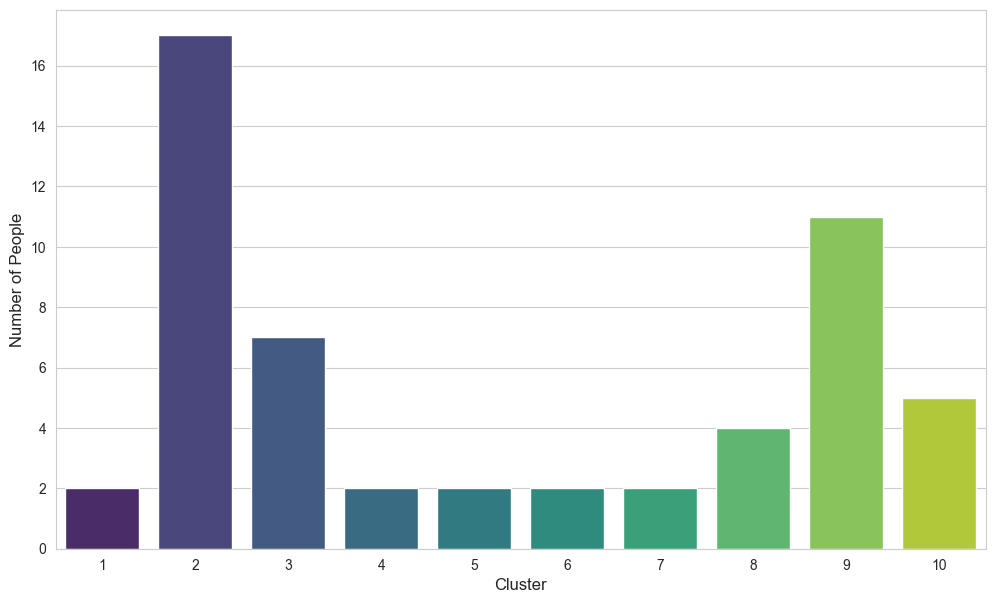

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the column you want to count
cluster_column = 'Modularity Class'

people_df[cluster_column]=people_df[cluster_column]+1

# Set the visual style for the plot
sns.set_style("whitegrid")

# Create a figure and axes for the plot to control its size
plt.figure(figsize=(12, 7))

# Use seaborn.countplot to automatically count the occurrences in the column and create a bar plot
ax = sns.countplot(x=cluster_column, data=people_df, palette='viridis')

# Add titles and labels for clarity
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Number of People', fontsize=12)

# Improve x-tick labels to ensure all cluster numbers are shown clearly
# This is useful if you have many clusters.
plt.xticks(rotation=0) 

# Display the plot
plt.show()



Not used in the end